In [1]:
import os
import logging
from pathlib import Path

import scanpy as sc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from einops import rearrange, reduce
from timm import create_model
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomResizedCrop, RandomRotation, Compose, CenterCrop
from typing import Optional, List

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
from mushroom.dataloaders import STDataset, MultisampleSTDataset
from mushroom.transforms import OverlaidHETransform
from mushroom.models.expression_prediction import STExpressionModel, STExpressionLightning
from mushroom.logging import LoggingCallback

## load data

In [6]:
genes = [
    'IL7R',
    'CD8A',
    'SPARC',
    'BGN',
    'VIM',
    'EPCAM',
    'KRT18',
    'MS4A1',
    'PECAM1',
]

In [7]:
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U4',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U5',
]

sid_to_adata = {}
for fp in fps:
    sid = fp.split('/')[-1]
    a = sc.read_visium(fp)
    a.var_names_make_unique()
    a = a[:, genes]
    sid_to_adata[sid] = a
sid_to_adata.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [8]:
fps = {
    'BR_206B1_U2': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif',
    'BR_206B1_U3': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif',
    'BR_206B1_U4': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U4.tif',
    'BR_206B1_U5': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U5.tif',
}

sid_to_he = {sid:tifffile.imread(fp) for sid, fp in fps.items()}
sid_to_he.keys()

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [9]:
means, stds = utils.get_means_and_stds(sid_to_adata.values())
means, stds

(array([0.74600196, 0.67650163, 0.8227606 ], dtype=float32),
 array([0.20359719, 0.2339519 , 0.13040961], dtype=float32))

In [23]:
sid = 'BR_206B1_U2'
size = (128, 128)
context_res = 2
scale = .2
max_voxels = 32

transform = OverlaidHETransform(p=1., size=(size[0] * context_res, size[1] * context_res),
                                means=means, stds=stds)

ds = STDataset(sid_to_adata[sid], sid_to_he[sid], transform=transform, scale=scale,
               max_voxels_per_sample=max_voxels, size=size)


keys: dict_keys(['he', 'labeled_img', 'context_he', 'context_labeled_img', 'voxel_idxs', 'masks', 'exp', 'n_voxels'])


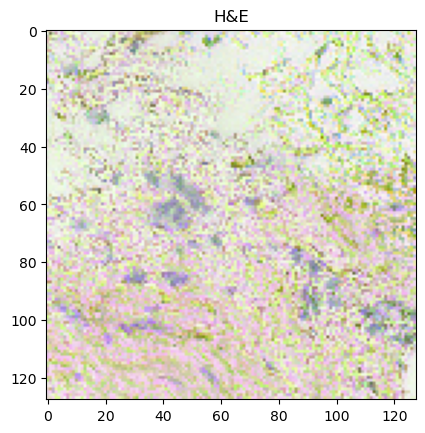

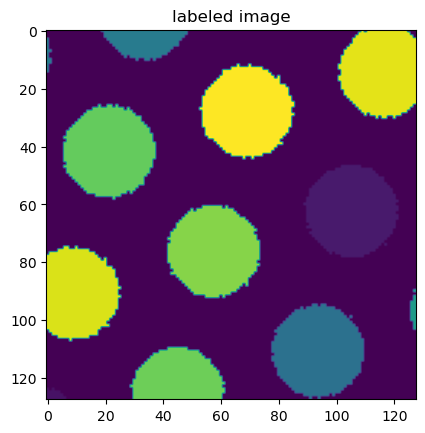

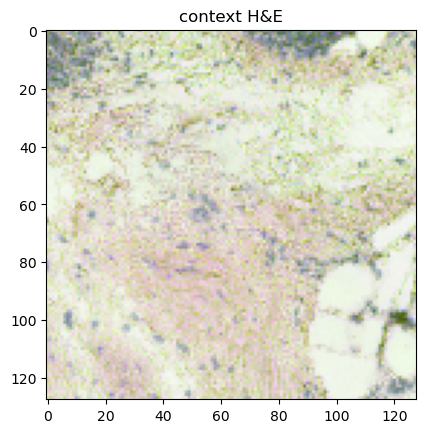

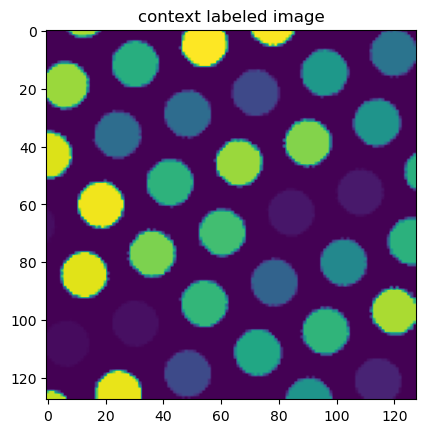

voxel idxs: tensor([ 246, 1251, 1400, 2557, 2611, 2746, 3162, 3217, 3350,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
labeled image voxel idxs: tensor([   0,  160,  246, 1251, 1400, 1406, 1842, 2557, 2611, 2746, 3162, 3217,
        3350], dtype=torch.int32)
masks shape: torch.Size([32, 128, 128])


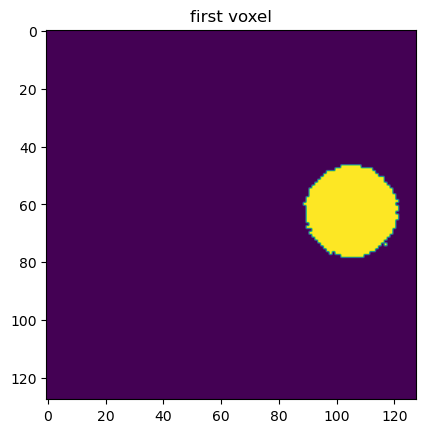

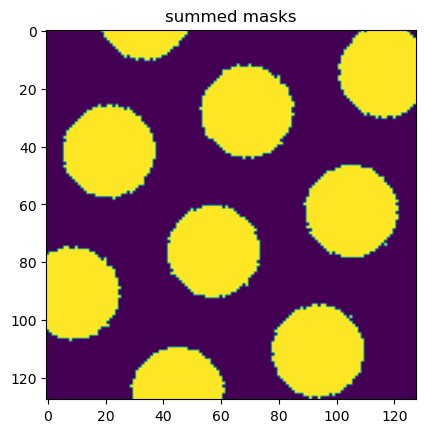

expression counts shape: torch.Size([32, 9])
tensor([[0., 0., 1., 1., 3., 1., 0., 0., 1.],
        [0., 0., 2., 1., 2., 0., 0., 0., 1.],
        [0., 0., 4., 0., 4., 0., 0., 0., 0.],
        [0., 0., 6., 1., 2., 1., 0., 0., 3.],
        [0., 0., 0., 1., 2., 0., 2., 0., 0.],
        [0., 0., 4., 4., 2., 0., 3., 0., 2.],
        [0., 0., 3., 2., 1., 0., 0., 0., 1.],
        [2., 0., 4., 1., 5., 1., 0., 0., 0.],
        [0., 0., 4., 0., 4., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

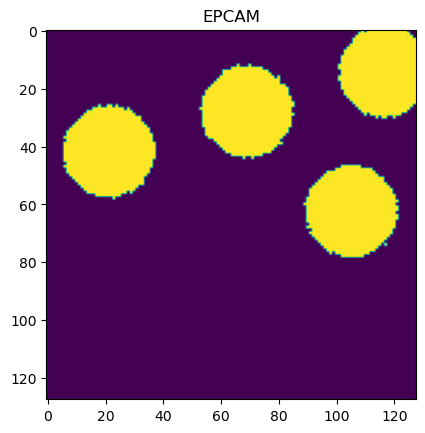

In [24]:
ds.sanity_check(gene='EPCAM')

In [25]:
train_sids = ['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4']
val_sids = ['BR_206B1_U5']

In [39]:
size = (128, 128)
context_res = 2
scale = .2
max_voxels = 64

train_transform = OverlaidHETransform(p=.95, size=(size[0] * context_res, size[1] * context_res),
                                means=means, stds=stds, )

sid_to_train_ds = {sid:STDataset(
                       sid_to_adata[sid], sid_to_he[sid], transform=train_transform, scale=scale,
                       max_voxels_per_sample=max_voxels)
                   for sid in train_sids}

In [40]:
val_transform = OverlaidHETransform(p=0., size=(size[0] * context_res, size[1] * context_res),
                                means=means, stds=stds)

sid_to_val_ds = {sid:STDataset(
                       sid_to_adata[sid], sid_to_he[sid], transform=val_transform, scale=scale,
                       max_voxels_per_sample=max_voxels)
                   for sid in val_sids}

In [41]:
train_ds = MultisampleSTDataset(sid_to_train_ds)
val_ds = MultisampleSTDataset(sid_to_val_ds)

In [42]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=60)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=20)

In [30]:
# b = next(iter(train_dl))

In [31]:
# for k in b.keys():
#     print(f'{k}: ' + str(b[k].shape))

## model

In [32]:
project = 'expression_model'
log_dir = '/data/estorrs/mushroom/data/models/expression_v1'
Path(log_dir).mkdir(parents=True, exist_ok=True)

In [51]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [52]:
# wandb.finish()

In [53]:
config = {
    'backbone': 'resnet34',
    'n_metagenes': 10,
    'he_scaler': 0.1,
    'kl_scaler': 0.001,
    'exp_scaler': 1.0,
    'training': {
        'log_n_samples': 8,
        'max_epochs': 200,
        'log_every': 10,
        'limit_train_batches': 1.,
        'limit_val_batches': .1,
        'accelerator': 'gpu',
        'devices': [1],
        'lr': 2e-5,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [54]:
m = STExpressionModel(
    genes,
    n_metagenes=10,
    he_scaler=0.1,
    kl_scaler=0.001,
    exp_scaler=1.0,
)

model = STExpressionLightning(m, lr=config['training']['lr'])

In [56]:
trainer = pl.Trainer(
    callbacks=[
        LoggingCallback(
            log_every=config['training']['log_every'],
            log_n_samples=config['training']['log_n_samples']
        ),
        ModelCheckpoint(
            dirpath=os.path.join(log_dir, "ckpts"),
            every_n_epochs=10,
#             save_top_k=3,
            monitor="val/overall_loss"
        )
    ],
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    enable_checkpointing=True,
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [ ]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /data/estorrs/mushroom/data/models/expression_v1/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params
--------------------------------------------
0 | model | STExpressionModel | 45.2 M
--------------------------------------------
45.2 M    Trainable params
0         Non-trainable params
45.2 M    Total params
180.604   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

torch.Size([8, 256, 256])


Training: 0it [00:00, ?it/s]

torch.Size([8, 256, 256])
